# Log 0.6
1. Trying the VGG16 model like in the pretrained-covnet-example, but with categorical class mode
2. back to 30 epocs
3. some overtraining, but higher accuracy a(t) ~ 0.95, a(v) ~ 0.7 and loss l(t) ~ .02, l(v) ~ 1
4. Idea: Save features and labels to avoid running them through the covnet repeatedly
5. Then try to add more dense layers with dropout and regularization to avoid overtraining


In [1]:
# print out data splits for all categories
import keras, os, shutil
#keras.__version__ 2.4.3


base = "data"
splits = ["training", "validating", "testing"]
categories = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
target_size = 128


for split in splits:
    for category in categories:
        path = os.path.join(base, split, category)
        print (path, "number of items:", len(os.listdir(path)))

data/training/cardboard number of items: 199
data/training/glass number of items: 199
data/training/metal number of items: 199
data/training/paper number of items: 199
data/training/plastic number of items: 299
data/training/trash number of items: 69
data/validating/cardboard number of items: 104
data/validating/glass number of items: 202
data/validating/metal number of items: 111
data/validating/paper number of items: 295
data/validating/plastic number of items: 183
data/validating/trash number of items: 38
data/testing/cardboard number of items: 100
data/testing/glass number of items: 100
data/testing/metal number of items: 100
data/testing/paper number of items: 100
data/testing/plastic number of items: 100
data/testing/trash number of items: 30


In [2]:
# import the VGG16 model
import numpy as np
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(target_size, target_size, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [7]:
#load data and extract features
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 6)) #added '6' to fit the number of classes
    generator = datagen.flow_from_directory(
        directory,
        target_size=(target_size, target_size),
        batch_size= batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features("data/training", 1160)#changed to fit sample size
validation_features, validation_labels = extract_features("data/validating", 920) #this one too
test_features, test_labels = extract_features("data/testing", 520) # and this

# reshape
train_features = np.reshape(train_features, (1160, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (920, 4 * 4 * 512))
test_features = np.reshape(test_features, (520, 4 * 4 * 512))

Found 1164 images belonging to 6 classes.
Found 933 images belonging to 6 classes.
Found 530 images belonging to 6 classes.


In [9]:
# build network and print summary
from keras import layers
from keras import models
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.summary()


# add optimizer
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 1,049,478
Trainable params: 1,049,478
Non-trainable params: 0
_________________________________________________________________


In [10]:
# train and save model
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

model.save('trash-classifier-0-6.h5')

Epoch 1/30
58/58 [==============================] - 3s 49ms/step - loss: 1.7918 - acc: 0.3552 - val_loss: 1.4752 - val_acc: 0.5033
Epoch 2/30
58/58 [==============================] - 3s 52ms/step - loss: 1.4057 - acc: 0.5362 - val_loss: 1.3007 - val_acc: 0.5783
Epoch 3/30
58/58 [==============================] - 3s 46ms/step - loss: 1.1942 - acc: 0.6534 - val_loss: 1.2018 - val_acc: 0.6141
Epoch 4/30
58/58 [==============================] - 3s 45ms/step - loss: 1.0582 - acc: 0.6776 - val_loss: 1.1002 - val_acc: 0.6565
Epoch 5/30
58/58 [==============================] - 3s 56ms/step - loss: 0.9780 - acc: 0.7026 - val_loss: 1.0916 - val_acc: 0.6304
Epoch 6/30
58/58 [==============================] - 3s 51ms/step - loss: 0.8854 - acc: 0.7526 - val_loss: 0.9769 - val_acc: 0.7098
Epoch 7/30
58/58 [==============================] - 3s 57ms/step - loss: 0.8188 - acc: 0.7647 - val_loss: 0.9557 - val_acc: 0.6913
Epoch 8/30
58/58 [==============================] - 3s 50ms/step - loss: 0.7346 - a

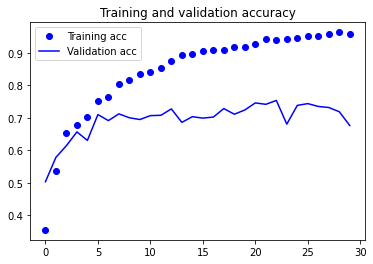

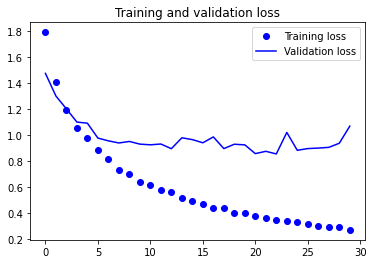

In [11]:
# plot accuracy and loss graphs
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()